# Initialisation of Dataset

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import dump
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Load CICIDS Dataset
def load_cicids_data(path, sample_size=10000):
    all_files = glob.glob(path + "/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        # Randomly sample 10,000 rows from each file (or less if the file has fewer rows)
        df_sampled = df.sample(n=min(sample_size, len(df)), random_state=42)
        df_list.append(df_sampled)

    df_cicids = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Binary encoding of labels: Normal (0), Attack (1)
    df_cicids['Label'] = df_cicids[' Label'].apply(lambda x: 0 if 'BENIGN' in x else 1)
    return df_cicids.drop(' Label', axis=1)

# Loading datasets (adjust file paths as necessary)
path_to_cicids = 'e:/Vishnupriya/Dataset/CICIDS 2017/'
df_cicids = load_cicids_data(path_to_cicids, sample_size=10000)

# Correlation Matrix

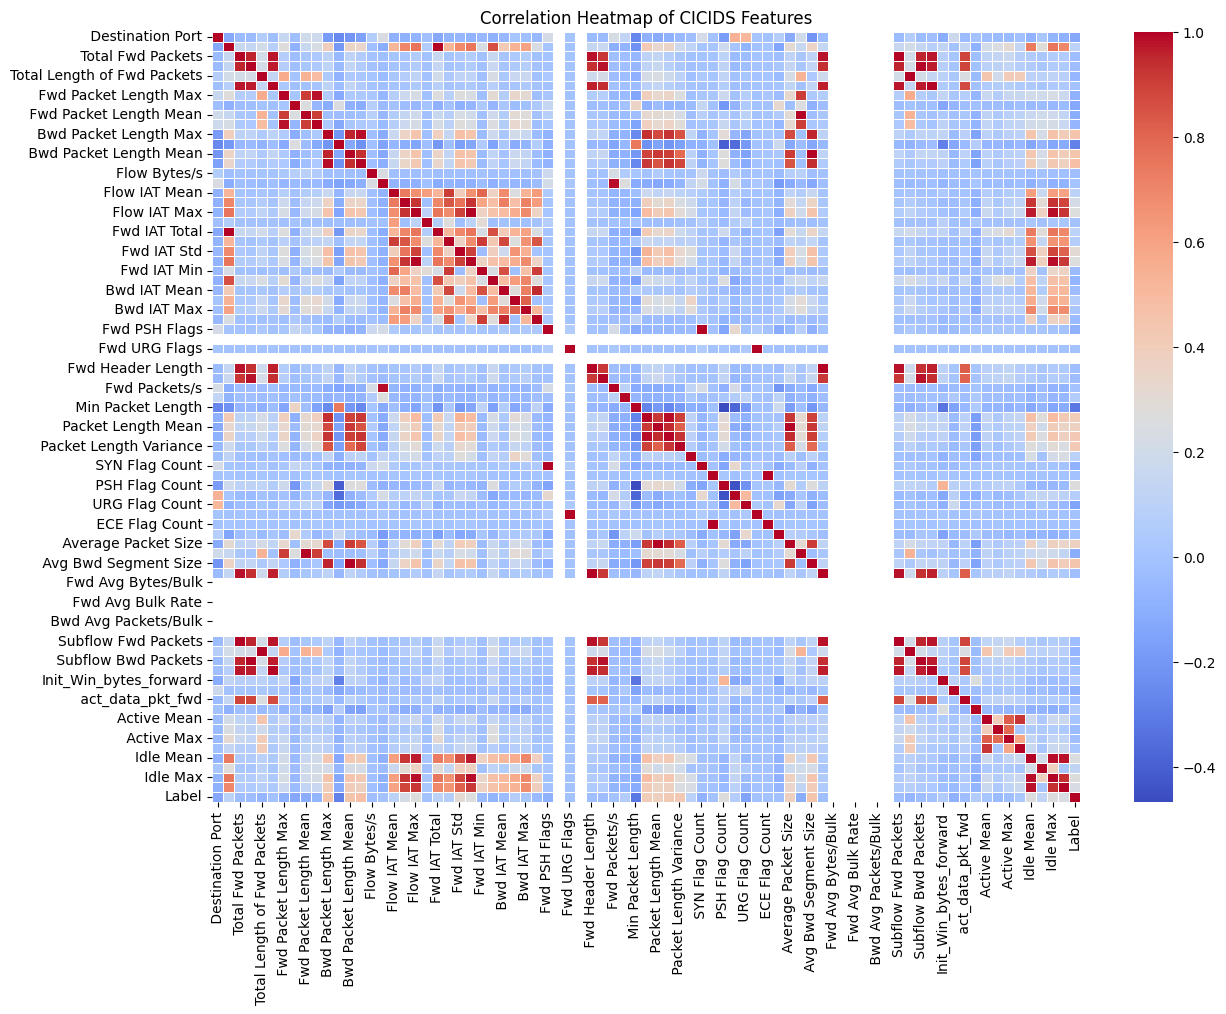

In [10]:
# Correlation matrix for feature selection and visualization
df_cicids_numeric = df_cicids.select_dtypes(include=[float, int])  # Ensure only numeric columns
correlation_matrix = df_cicids_numeric.corr()

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of CICIDS Features')
plt.show()

# Data Preprocessing

In [2]:
# Handle NaN and infinite values
df_cicids.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
df_cicids.fillna(df_cicids.median(), inplace=True)

# Preprocessing: feature scaling
scaler = StandardScaler()

# CICIDS
X_cicids = df_cicids.drop('Label', axis=1)
y_cicids = df_cicids['Label']
X_train_cicids, X_test_cicids, y_train_cicids, y_test_cicids = train_test_split(X_cicids, y_cicids, test_size=0.2, random_state=42)

# Impute missing values using median
imputer = SimpleImputer(strategy='median')

# Impute and scale CICIDS data
X_train_cicids_imputed = imputer.fit_transform(X_train_cicids)
X_test_cicids_imputed = imputer.transform(X_test_cicids)

# Apply scaling
X_train_cicids_scaled = scaler.fit_transform(X_train_cicids_imputed)
X_test_cicids_scaled = scaler.transform(X_test_cicids_imputed)

# Function to upsample minority class (attacks)
def handle_imbalance(df_train, label_col):
    majority_class = df_train[df_train[label_col] == 0]
    minority_class = df_train[df_train[label_col] == 1]
    
    # Upsample minority class to match majority
    minority_upsampled = resample(minority_class, 
                                  replace=True, 
                                  n_samples=len(majority_class), 
                                  random_state=42)
    
    # Combine majority and upsampled minority
    upsampled_df = pd.concat([majority_class, minority_upsampled])
    return upsampled_df

# Apply to each dataset (CICIDS, NSL-KDD, UNSW-NB15)
df_cicids_train_balanced = handle_imbalance(pd.concat([pd.DataFrame(X_train_cicids_scaled), y_train_cicids.reset_index(drop=True)], axis=1), 'Label')
X_train_cicids_balanced = df_cicids_train_balanced.drop('Label', axis=1)
y_train_cicids_balanced = df_cicids_train_balanced['Label']




C:\Users\banot\AppData\Local\Temp\ipykernel_17892\1974007423.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cicids.fillna(df_cicids.median(), inplace=True)


# Evaluation Methods

In [13]:
# Train and evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation metrics for {model_name}:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"ROC AUC Score: {roc_auc:.4f}\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title(f"Confusion Matrix for {model_name} on UNSW-NB15")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Random Forest Classifier

Evaluation metrics for Random Forest:
Accuracy: 0.9982
Precision: 0.9958
Recall: 0.9951
F1-Score: 0.9955
ROC AUC Score: 0.9971



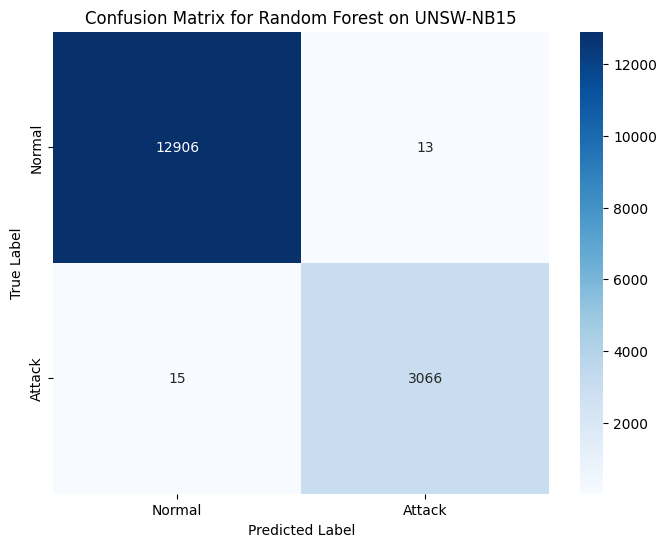

In [15]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_cicids_balanced, y_train_cicids_balanced)
y_pred_rf = rf_model.predict(X_test_cicids_scaled)

# Save Random Forest model
dump(rf_model, 'rf_model_cicids.joblib')
evaluate_model(y_test_cicids, y_pred_rf, "Random Forest")


# XGBoost Classifier

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation metrics for XGBoost:
Accuracy: 0.9988
Precision: 0.9955
Recall: 0.9984
F1-Score: 0.9969
ROC AUC Score: 0.9986



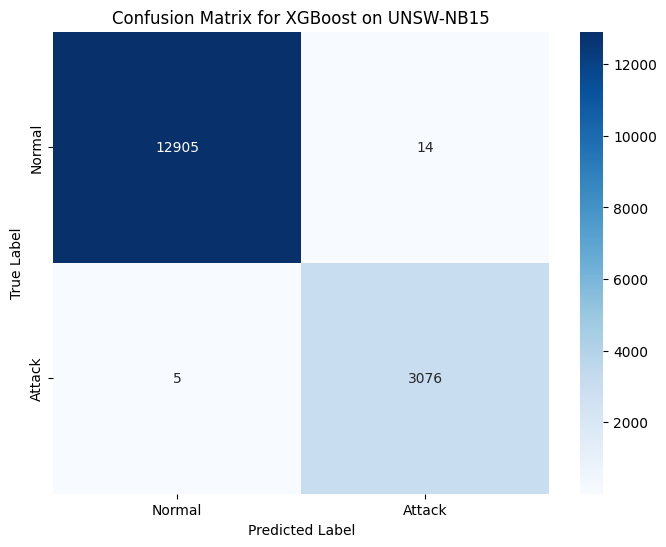

In [16]:
# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_cicids_balanced, y_train_cicids_balanced)
y_pred_xgb = xgb_model.predict(X_test_cicids_scaled)

# Save XGBoost model
dump(xgb_model, 'xgb_model_cicids.joblib')
evaluate_model(y_test_cicids, y_pred_xgb, "XGBoost")

# Isolation Forest

Evaluation metrics for Isolation Forest:
Accuracy: 0.7907
Precision: 0.4199
Recall: 0.2278
F1-Score: 0.2954
ROC AUC Score: 0.5764



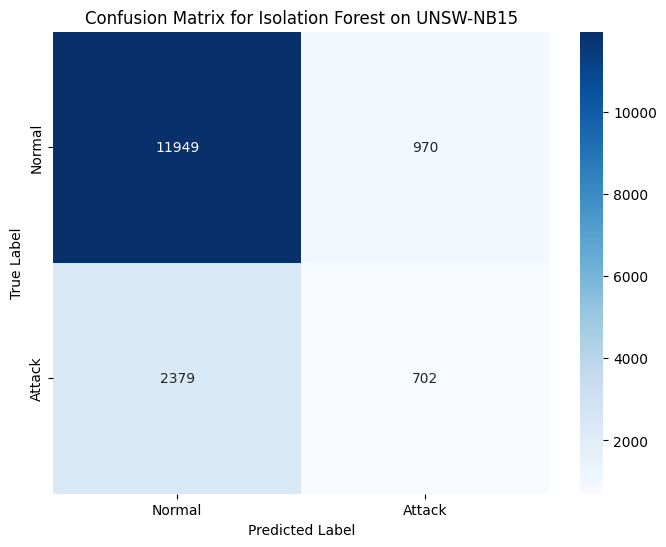

In [17]:
# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_cicids_scaled)
y_pred_iso = iso_forest.predict(X_test_cicids_scaled)
y_pred_iso = [0 if pred == 1 else 1 for pred in y_pred_iso]  # Convert to binary labels

# Save Isolation Forest model
dump(iso_forest, 'iso_forest_model_cicids.joblib')
evaluate_model(y_test_cicids, y_pred_iso, "Isolation Forest")

# Autoencoder

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6876 - val_loss: 0.6113
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6859 - val_loss: 0.6078
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6760 - val_loss: 0.6064
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6593 - val_loss: 0.6051
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6617 - val_loss: 0.6049
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7144 - val_loss: 0.6029
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7211 - val_loss: 0.6027
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6327 - val_loss: 0.6024
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6849 - val_loss: 0.6018
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7014 - val_loss: 0.6017
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6730 - val_loss: 0.6013
Epoch 12/50
2000/2000 ━━━━━━━━

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Evaluation metrics for Autoencoder:
Accuracy: 0.8029
Precision: 0.4550
Recall: 0.1181
F1-Score: 0.1876
ROC AUC Score: 0.5422



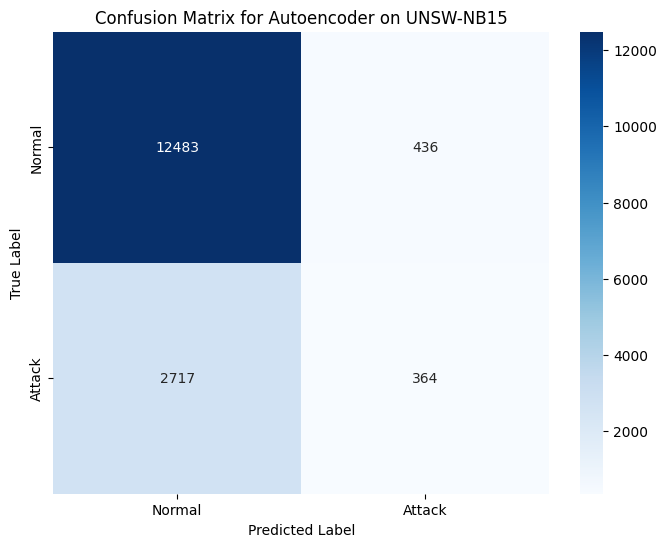

In [18]:
# Autoencoder for anomaly detection
def create_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))
    return model

autoencoder = create_autoencoder(X_train_cicids_scaled.shape[1])
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_train_cicids_scaled, X_train_cicids_scaled, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test_cicids_scaled, X_test_cicids_scaled))

# Save Autoencoder model
autoencoder.save('autoencoder_model_cicids.h5')

# Anomaly detection using Autoencoder
reconstructed = autoencoder.predict(X_test_cicids_scaled)
loss = np.mean(np.abs(reconstructed - X_test_cicids_scaled), axis=1)
threshold = np.percentile(loss, 95)  # Adjust based on desired sensitivity
y_pred_autoencoder = [1 if i > threshold else 0 for i in loss]

# Evaluate Autoencoder
evaluate_model(y_test_cicids, y_pred_autoencoder, "Autoencoder")
